## Analyzing Nanopore m6A sequencing results from xPore (CPU-based)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Introduction

Similar to some methods, RNA modifications might leave some errors around the modified base. Normally, this will happen within the 5-mers window covering the base. Currently, we don't have perfect computational methods to retrive all of the real signal from fast5 files generated by Nanopore. In the base call results, there should be a lot of noise, but also some modification out of our model. Hence, it is valuable for us to re-analyze Nanopore data.

In this notebook, I will introduce the method ensuring us to handle the phase mismatch issue in Nanopore, i.e., the base we called from Nanopore might not correctly fall back to the right position in the genome, but have 1 to 2 base shift in the 5-mers window. This method require the appropriate estimation function in HDBSCAN, which is recently available in the CPU version (Jan, 2022. RAPIDS's version is coming soon).

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27

## 0.1 Configure environment

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

tracemalloc.start()

## 0.2 Define functions

In [2]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean'):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap, metric=metric)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [3]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [4]:
def subcluster_HDBSCAN(df, target=None, cluster_col="Cluster", min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, alpha=1., cluster_selection_method='leaf', draw_condensed_tree=True, soft_clustering=True):
    # use multi-code here
    df = df.copy()
    max_cluster_id = df[cluster_col].max()
    
    df1 = df[df[cluster_col]==target].copy()
    
    X = np.stack([df1["X"], df1["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=50, cluster_selection_method=cluster_selection_method, alpha=1., core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df1[cluster_col] = [max_cluster_id + i + 1 for i in labels ]  # re-number lables to make it human-readable
    df.loc[df1.index, cluster_col] = df1[cluster_col].tolist()
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    # print("==================================================")
    # check cluster number
    print(df.groupby(cluster_col)[cluster_col].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model

In [5]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [6]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [7]:
def show_logos(prefix, names=None):
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        plt.figure()
        image = plt.imread(prefix+"/"+img)
        plt.imshow(image)
        plt.axis("off")

In [8]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if len(file_list_format) > 1:
        for ax, image in zip(*[axes.reshape(-1), file_list_format]):
            fn, id = image
            img = plt.imread(prefix+"/"+fn)
            _ = ax.imshow(img)
            ax.set_title("cluster_{}".format(id))
        for ax in axes.reshape(-1):
            ax.axis("off")
    else:
        image = file_list_format[0]
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = axes.imshow(img)
        axes.set_title("cluster_{}".format(id))
        axes.axis("off")
    plt.tight_layout()

In [9]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

## 1. Load data

Supplementary TableS3 of xPore (doi.org/10.1038/s41587-021-00949-w) was used in this analysis.

We add the flaning 14-nt sequences to the table, which covering all 5-kmers including the potential methylation site.

In [10]:
dict_all_5mers = {-4: {}, -3: {}, -2: {}, -1: {}, 0: {}, 1: {}, 2: {}, 3: {}, 4: {}}
dfs = []
def load_sequences_from_csv(fn, sample_name):
    from Bio import SeqIO
    
    global dfs
    indexes = []
    
    if fn.endswith(".csv"):
        for idx, row in pd.read_csv(fn, index_col=None, header=0).iterrows():
            seq = str(row["motif_F14"]).upper()
            if  len(seq) != 29:
                continue
            ID = "{}@{}@{}".format(row["chr"], row["id"], row["position"])
            # get all types of 5-mers
            for i in range(0, 9):
                kmers_id = i - 4
                dict_all_5mers[kmers_id][ID] = seq[i: i+21]
            indexes.append(ID)
    subdf = pd.DataFrame(index=indexes, columns=[sample_name])
    subdf = subdf[~subdf.index.duplicated(keep='first')]
    subdf[sample_name] = True
    dfs.append(subdf)

**Different from normal analysis, we don't require we have a "A" at the center at first**

In [11]:
load_sequences_from_csv("Xpore_m6A_TableS3.F14.csv", "xPore")
df_xPore_init = pd.concat(dfs, axis=1)
print(df_xPore_init.shape)

(7193, 1)


In [12]:
# set pointer at 0
df_xPore_init["motif_F10"] = df_xPore_init.apply(lambda x: dict_all_5mers[0].get(x.name), axis=1)
df_xPore_init["Center_base"] = df_xPore_init.apply(lambda x: x["motif_F10"][10], axis=1)
print(df_xPore_init.groupby("Center_base")["Center_base"].count())

Center_base
A    2518
C    1450
G     938
T    2287
Name: Center_base, dtype: int64


**Get one-hot**

In [13]:
onehot_input = []
for idx, row in df_xPore_init.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

## 2. Run UMAP and HDBSCAN

In [14]:
_, _, df_xPore_init = UMAP(onehot_input, df_xPore_init)

UMAP
UMAP time: 216.73966574668884 sec
UMAP RAM: 75.11585140228271 MB



HDBSCAN soft clustering time: 0.8937849998474121 sec
HDBSCAN soft clustering RAM: 27.019737243652344 Mb
HDBSCAN cluster number: 9
Cluster
1     665
2    2185
3     596
4     508
5     704
6     785
7     635
8     489
9     626
Name: Cluster, dtype: int64


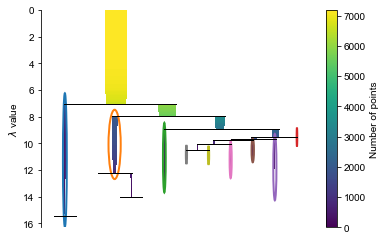

In [15]:
# 100 10
_, _, df_xPore_init, _ = cluster_HDBSCAN(df_xPore_init, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True)

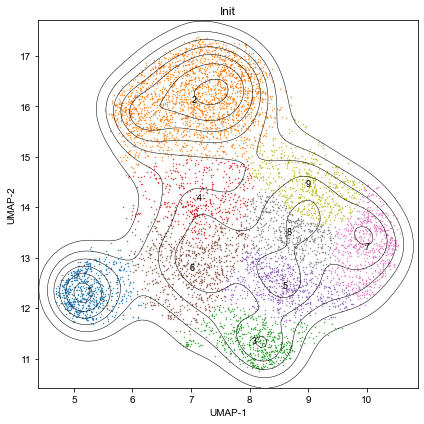

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_xPore_init, title="Init")
plt.tight_layout()
plt.savefig("xPore.init.pdf")

In [17]:
extract_fasta_and_draw_motifs("xPore_direct_clustering", df_xPore_init)

===============  xPore_direct_clustering ===============
Cluster #1: 665
Cluster #2: 2185
Cluster #3: 596
Cluster #4: 508
Cluster #5: 704
Cluster #6: 785
Cluster #7: 635
Cluster #8: 489
Cluster #9: 626


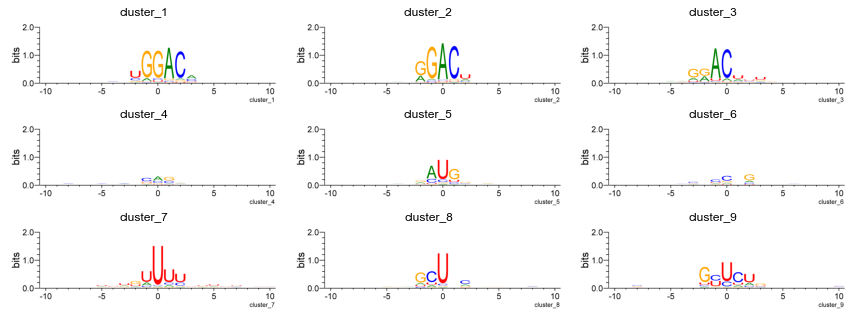

In [18]:
show_logos_cols("./xPore_direct_clustering/logos_bits_png/", cols=3)

In [19]:
def draw_one_sample_ATCGN(ax, df, center_col="Center_base", draw_base=None, s=0.2, alpha=1.0):
    subdf = df[df[center_col]==draw_base]
    background = df[df[center_col]!=draw_base]
    
    ax.scatter(background["X"], background["Y"], s=s, alpha=alpha, lw=None, c="lightgray")
    ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, c="black")
    
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(draw_base)

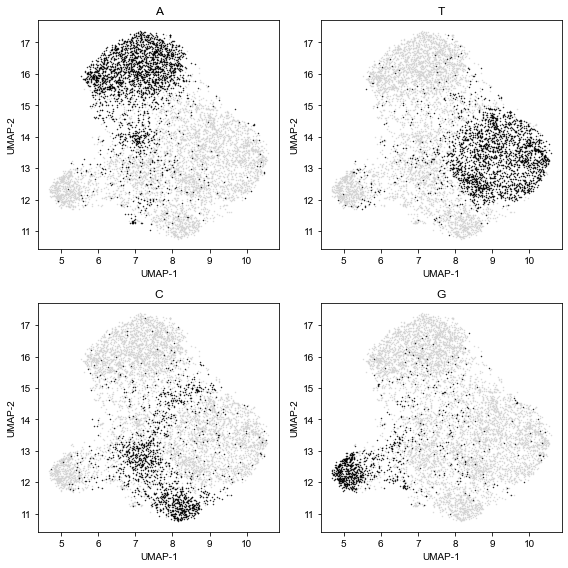

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for ax, base in zip(*[axes.reshape(-1),["A", "T", "C", "G"]]):
    draw_one_sample_ATCGN(ax, df_xPore_init, center_col="Center_base", draw_base=base, s=0.2, alpha=1.0)
plt.tight_layout()
plt.savefig("xPore.init.bases.png", dpi=300)

**Let's chek the phase of the sequences.**

Here we found that, we can direct recognize cluster \#1 (+1 phase), cluster \#2 (correct phase), cluster \#3 (-1 phase) as RRACH motif, but .

We also found cluster \#4 (correct phase) in a CAG motif for m6Am

What we shoud do now is to shift the sequences in cluster \#1 and cluster \#2 to make the correct A cluster bigger.


[468, 1384, 2518, 944, 294]
[123, 592, 2323, 565, 81]


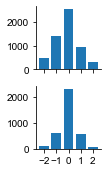

In [21]:
# draw center bases
Xs = [-2, -1, 0, 1, 2]
def get_base_counts(df):
    m2, m1, cent, p1, p2 = 0, 0, 0, 0,0
    for idx, row in df.iterrows():
        motif = row["motif_F10"]
        base_center = motif[10]
        base_m1 = motif[9]
        base_m2 = motif[8]
        base_p1 = motif[11]
        base_p2 = motif[12]
        if base_center == "A":
            cent += 1
        else:
            if base_m1 == "A":
                m1 += 1
            else:
                if base_p1 == "A":
                    p1 += 1
                else:
                    if base_m2 == "A":
                        m2 += 1
                    else:
                        if base_p2 == "A":
                            p2 += 1
    return [m2, m1, cent, p1, p2]
Ys_ori = get_base_counts(df_xPore_init)
Ys_1234 = get_base_counts(df_xPore_init[df_xPore_init["Cluster"].isin([1,2,3,4])==True])
Ys_12345 = get_base_counts(df_xPore_init[df_xPore_init["Cluster"].isin([1,2,3,4,5])==True])

print(Ys_ori)
print(Ys_1234)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette("tab10")) 
fig, axes = plt.subplots(2,1, sharex=True,figsize=(1.6,2.5))
axes[0].bar(Xs, Ys_ori)
axes[1].bar(Xs, Ys_1234)
axes[1].set_xticks(Xs)
sns.despine()
plt.tight_layout()
plt.savefig("A_shifts.pdf")
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette("Set2")) 

## 3. Phase fix of specific clusters

In [22]:
def phase_shift(df, cluster_id=None, current_A_phase=0):
    df = df.copy()
    indexes = []
    shifted_seq = []
    for idx, row in df.iterrows():
        if row["Cluster"]==cluster_id and row["Center_base"]!="A":
            if row["motif_F10"][10] != "A" and row["motif_F10"][10+current_A_phase] == "A":
                indexes.append(idx)
                shifted_seq.append(dict_all_5mers[current_A_phase][idx])
    df.loc[indexes, "Phase_shift"] = current_A_phase
    df.loc[indexes, "motif_F10"] = shifted_seq
    df.loc[indexes, "Center_base"] = "A"
    return df

In [23]:
df_xPore = df_xPore_init.copy()
df_xPore["Phase_shift"] = 0  # positon + Phase_shift = now_corr of motif_F10

df_xPore_round_1 = phase_shift(df_xPore, cluster_id=1, current_A_phase=1)
df_xPore_round_1 = phase_shift(df_xPore_round_1, cluster_id=3, current_A_phase=-1)

**Regenerate one-hot**

In [24]:
onehot_input = []
for idx, row in df_xPore_round_1.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

**UMAP agian**

In [25]:
_, _, df_xPore_round_1 = UMAP(onehot_input, df_xPore_round_1, densmap=False) 

UMAP
UMAP time: 21.478890657424927 sec
UMAP RAM: 119.01415348052979 MB



HDBSCAN soft clustering time: 0.802121639251709 sec
HDBSCAN soft clustering RAM: 113.91344261169434 Mb
HDBSCAN cluster number: 2
Cluster
1    3454
2    3739
Name: Cluster, dtype: int64


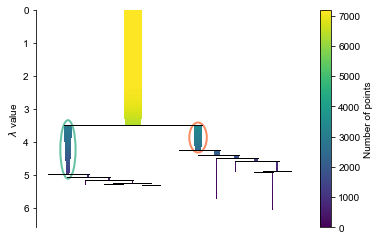

In [26]:
_, _, df_xPore_round_1, _ = cluster_HDBSCAN(df_xPore_round_1, min_cluster_size=50, min_samples=50, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True) 

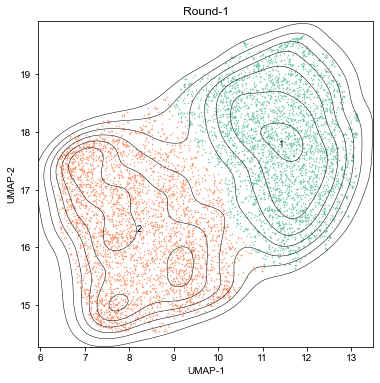

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_xPore_round_1, title="Round-1")
plt.savefig("xPore.round1.pdf")

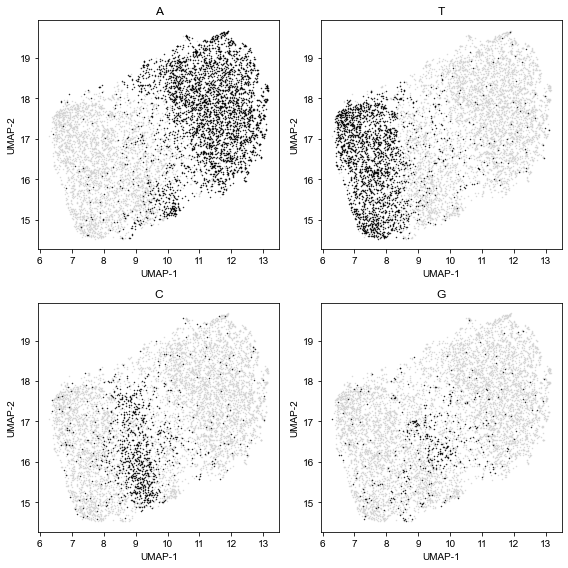

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for ax, base in zip(*[axes.reshape(-1),["A", "T", "C", "G"]]):
    draw_one_sample_ATCGN(ax, df_xPore_round_1, center_col="Center_base", draw_base=base, s=0.2, alpha=1.0)
plt.tight_layout()
plt.savefig("xPore.round2.bases.png", dpi=300)

**Beautiful!**

In [29]:
print(df_xPore_round_1.groupby("Center_base")["Center_base"].count())

Center_base
A    3550
C     973
G     417
T    2253
Name: Center_base, dtype: int64


===============  xPore_shift_1_A ===============
Cluster #1: 3132
Cluster #2: 418


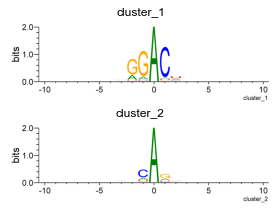

In [30]:
extract_fasta_and_draw_motifs("xPore_shift_1_A", df_xPore_round_1[df_xPore_round_1["Center_base"]=="A"])
show_logos_cols("./xPore_shift_1_A/logos_bits_png/", cols=1)

===============  xPore_shift_1_T ===============
Cluster #1: 97
Cluster #2: 2156


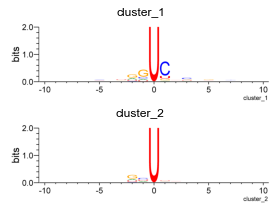

In [31]:
extract_fasta_and_draw_motifs("xPore_shift_1_T", df_xPore_round_1[df_xPore_round_1["Center_base"]=="T"])
show_logos_cols("./xPore_shift_1_T/logos_bits_png/", cols=1)

===============  xPore_shift_1_C ===============
Cluster #1: 118
Cluster #2: 855


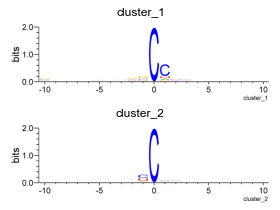

In [32]:
extract_fasta_and_draw_motifs("xPore_shift_1_C", df_xPore_round_1[df_xPore_round_1["Center_base"]=="C"])
show_logos_cols("./xPore_shift_1_C/logos_bits_png/", cols=1)

===============  xPore_shift_1_G ===============
Cluster #1: 107
Cluster #2: 310


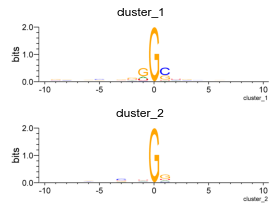

In [33]:
extract_fasta_and_draw_motifs("xPore_shift_1_G", df_xPore_round_1[df_xPore_round_1["Center_base"]=="G"])
show_logos_cols("./xPore_shift_1_G/logos_bits_png/", cols=1)

**Interestingly, except for normal m6A and m6Am motif, we also found a huge cluster of RRUCH motif. This might result from the m6A call program itself.**

In [34]:
df_xPore_round_1.to_csv("xPore_round1.csv")

## 4. Analyzing A and T bases

### 4.1 A bases

In [35]:
df_xPore_round_1_A = df_xPore_round_1[df_xPore_round_1["Center_base"]=="A"]

In [36]:
onehot_input = []
for idx, row in df_xPore_round_1_A.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

In [37]:
_, _, df_xPore_round_1_A = UMAP(onehot_input, df_xPore_round_1_A, densmap=False) 

UMAP
UMAP time: 24.343620538711548 sec
UMAP RAM: 197.1924285888672 MB



HDBSCAN soft clustering time: 0.35895729064941406 sec
HDBSCAN soft clustering RAM: 580.6432828903198 Mb
HDBSCAN cluster number: 2
Cluster
1     375
2    3175
Name: Cluster, dtype: int64


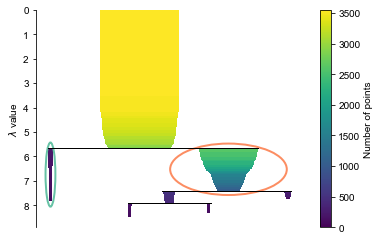

In [38]:
_, _, df_xPore_round_1_A, _ = cluster_HDBSCAN(df_xPore_round_1_A, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True) 

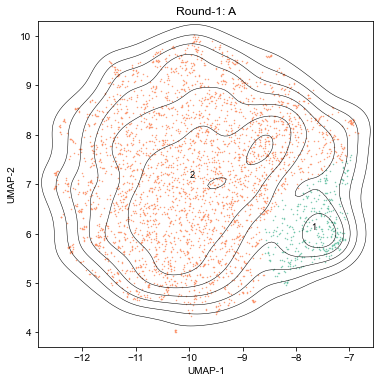

In [39]:
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_xPore_round_1_A, title="Round-1: A")
plt.savefig("xPore.round1.A.pdf")

In [40]:
df_xPore_round_1_A.to_csv("xPore.round1.A.csv")

In [41]:
extract_fasta_and_draw_motifs("xPore_round_1_A", df_xPore_round_1_A)

===============  xPore_round_1_A ===============
Cluster #1: 375
Cluster #2: 3175


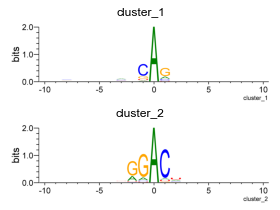

In [42]:
show_logos_cols("./xPore_round_1_A/logos_bits_png/", cols=1)

### 4.2 T bases

In [43]:
df_xPore_round_1_T = df_xPore_round_1[df_xPore_round_1["Center_base"]=="T"]

In [44]:
onehot_input = []
for idx, row in df_xPore_round_1_T.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

In [45]:
_, _, df_xPore_round_1_T = UMAP(onehot_input, df_xPore_round_1_T, densmap=False) 

UMAP
UMAP time: 10.884708881378174 sec
UMAP RAM: 482.8475065231323 MB



HDBSCAN soft clustering time: 0.224212646484375 sec
HDBSCAN soft clustering RAM: 477.1308364868164 Mb
HDBSCAN cluster number: 3
Cluster
1     532
2     634
3    1087
Name: Cluster, dtype: int64


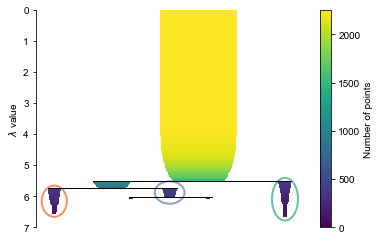

In [46]:
_, _, df_xPore_round_1_T, _ = cluster_HDBSCAN(df_xPore_round_1_T, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True) 

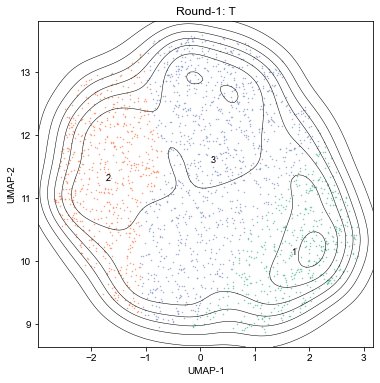

In [47]:
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_xPore_round_1_T, title="Round-1: T")
plt.savefig("xPore.round1.T.pdf")

In [48]:
df_xPore_round_1_T.to_csv("xPore.round1.T.csv")

In [49]:
extract_fasta_and_draw_motifs("xPore_round_1_T", df_xPore_round_1_T)

===============  xPore_round_1_T ===============
Cluster #1: 532
Cluster #2: 634
Cluster #3: 1087


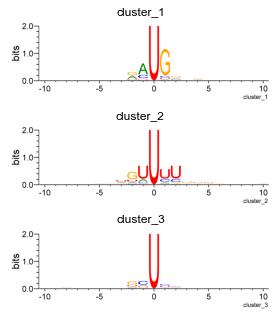

In [50]:
show_logos_cols("./xPore_round_1_T/logos_bits_png/", cols=1)

### 4.3 C bases

In [51]:
df_xPore_round_1_C = df_xPore_round_1[df_xPore_round_1["Center_base"]=="C"]

In [52]:
onehot_input = []
for idx, row in df_xPore_round_1_C.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

HDBSCAN soft clustering time: 0.04407143592834473 sec
HDBSCAN soft clustering RAM: 333.14075756073 Mb
HDBSCAN cluster number: 1
Cluster
1    973
Name: Cluster, dtype: int64


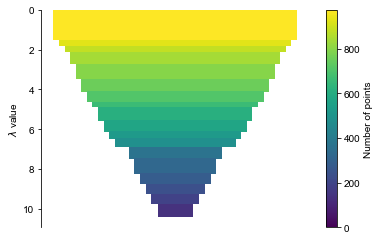

In [53]:
_, _, df_xPore_round_1_C, _ = cluster_HDBSCAN(df_xPore_round_1_C, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True) 

In [54]:
df_xPore_round_1_C.to_csv("xPore.round1.C.csv")

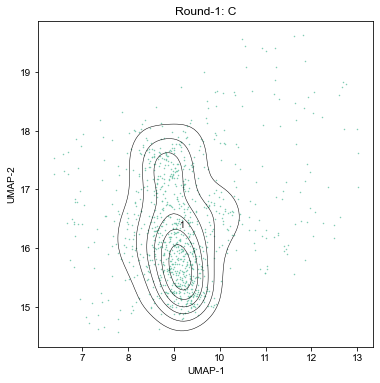

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_xPore_round_1_C, title="Round-1: C")
plt.savefig("xPore.round1.C.pdf")

In [56]:
extract_fasta_and_draw_motifs("xPore_round_1_C", df_xPore_round_1_C)

===============  xPore_round_1_C ===============
Cluster #1: 973


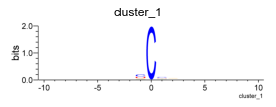

In [57]:
show_logos_cols("./xPore_round_1_C/logos_bits_png/", cols=1)

### 4.4 G bases

In [58]:
df_xPore_round_1_G = df_xPore_round_1[df_xPore_round_1["Center_base"]=="G"]

In [59]:
onehot_input = []
for idx, row in df_xPore_round_1_G.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

HDBSCAN soft clustering time: 0.021146535873413086 sec
HDBSCAN soft clustering RAM: 284.3851776123047 Mb
HDBSCAN cluster number: 1
Cluster
1    417
Name: Cluster, dtype: int64


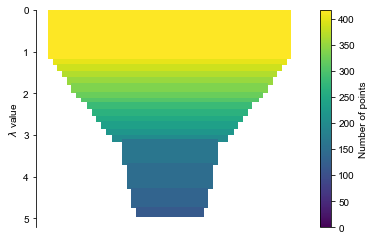

In [60]:
_, _, df_xPore_round_1_G, _ = cluster_HDBSCAN(df_xPore_round_1_G, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True) 

In [61]:
df_xPore_round_1_G.to_csv("xPore.round1.G.csv")

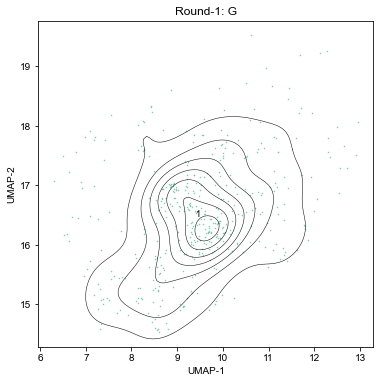

In [62]:
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_xPore_round_1_G, title="Round-1: G")
plt.savefig("xPore.round1.G.pdf")

In [63]:
extract_fasta_and_draw_motifs("xPore_round_1_G", df_xPore_round_1_G)

===============  xPore_round_1_G ===============
Cluster #1: 417


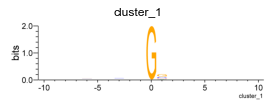

In [64]:
show_logos_cols("./xPore_round_1_G/logos_bits_png/", cols=1)